In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from glob import glob
from PIL import Image as pil_image

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [3]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [01:47<00:00, 68.1MB/s]
100% 5.20G/5.20G [01:48<00:00, 51.6MB/s]


In [4]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [5]:
df_skin = pd.read_csv('HAM10000_metadata.csv')
df_skin.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
# lesion names are given in the description of the challenge
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']

lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']

df_skin['lesion_type']=df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)

print('Total number of images',len(df_skin))
print('The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels')

df_skin['lesion_type'].value_counts()

Total number of images 10015
The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels


Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: lesion_type, dtype: int64

In [33]:
import os
#pil_image = os.path.join('images')
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('', '*', '*.jpg'))}

In [35]:
df_skin['path'] = df_skin['image_id'].map(image_path.get)
df_skin.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion_type,lesion_ID,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,ham10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,ham10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,ham10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,ham10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,ham10000_images_part_2/ISIC_0031633.jpg


In [38]:
# read the first image
df_skin['image'] = df_skin['path'].map(lambda x: np.asarray(pil_image.open(x).resize((100,100))))

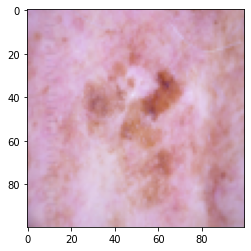

In [40]:
plt.imshow(df_skin['image'][0])

In [42]:
# import images from 2 different folders

X = []
y = []

lista1 = os.listdir('HAM10000_images_part_1/')
lista2 = os.listdir('HAM10000_images_part_2/')


#import images from folder 1
for i in range(len(lista1)):
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg','')
    
    #features 
    file_to_read ='HAM10000_images_part_1/'+str(fname_image)
    img = imread(file_to_read)
    img2 = resize(img,(100,100))
    X.append(img2)
    
    #targets
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # add more images for class between 1-6, rotating them 
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            X.append(new_img[i])
            y.append(output[0])
       
    if i % int(100) == 0:
        print(i,'images loaded')

# import images from folder 2
for i in range(len(lista2)):
    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg','')
    
    #features
    file_to_read ='HAM10000_images_part_2/'+str(fname_image)
    img = imread(file_to_read)
    img2 = resize(img,(100,100))
    X.append(img2)
    
    #targets
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # add more images for class between 1-6
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            X.append(new_img[i])
            y.append(output[0])
    
    if i % int(100) == 0:

        print(len(lista1)+i,'images loaded')

0 images loaded
100 images loaded
300 images loaded
400 images loaded
500 images loaded
1000 images loaded
1100 images loaded
1300 images loaded
1500 images loaded
1600 images loaded
1700 images loaded
1800 images loaded
1900 images loaded
2000 images loaded
2300 images loaded
2400 images loaded
2500 images loaded
2600 images loaded
2800 images loaded
2900 images loaded
3100 images loaded
3200 images loaded
3400 images loaded
3500 images loaded
3600 images loaded
3700 images loaded
3800 images loaded
3900 images loaded
4000 images loaded
4200 images loaded
4400 images loaded
4500 images loaded
4600 images loaded
4700 images loaded
4800 images loaded
5000 images loaded
5100 images loaded
5400 images loaded
5600 images loaded
5900 images loaded
6100 images loaded
6300 images loaded
6400 images loaded
6500 images loaded
6700 images loaded
6800 images loaded
6900 images loaded
7100 images loaded
7400 images loaded
7500 images loaded
7700 images loaded
7800 images loaded
7900 images loaded


In [43]:
from keras.utils.np_utils import to_categorical

X = np.array(X)
y = np.array(y)

y_train = to_categorical(y, num_classes=7)

# #convert targets in dummy variables, as required by softmax activation function
# y_dumm = np.array(pd.get_dummies(y))

In [44]:
from sklearn.model_selection import train_test_split

# split in 80% training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.33, random_state=50,stratify=y)


print('Train dataset shape',X_train.shape)
print('Test dataset shape',X_test.shape)

Train dataset shape (17798, 100, 100, 3)
Test dataset shape (8767, 100, 100, 3)


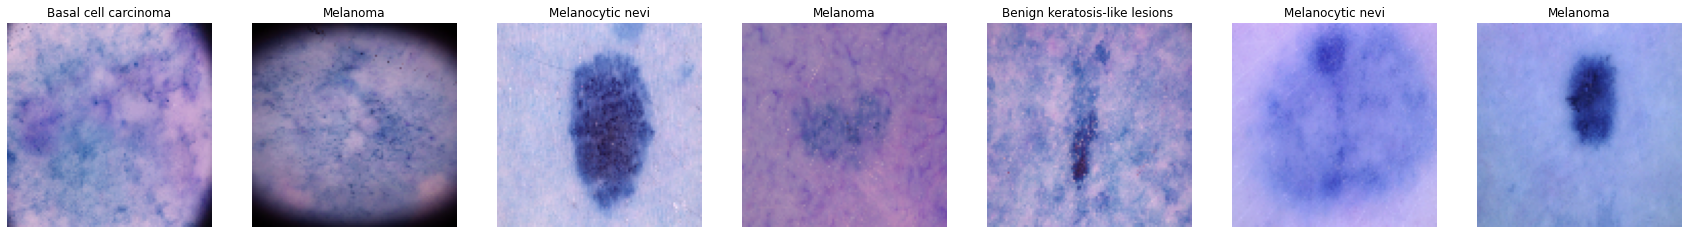

In [45]:
fig, ax = plt.subplots(1, 7, figsize=(30, 30))
for i in range(7):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(lesion_names[np.argmax(y_train[i])])

In [46]:
import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D,BatchNormalization,MaxPool2D,Flatten,Dense

In [47]:
from sklearn.utils.class_weight import compute_class_weight
y_id = np.array(df_skin['lesion_ID'])

# compute weights for the loss function, because the problem is unbalanced
class_weights = np.around(compute_class_weight(class_weight='balanced',classes=np.unique(y_id),y=y),2)
class_weights = dict(zip(np.unique(y_id),class_weights))

print('The problem is unbalanced. We need to provide class_weights ')
print(class_weights)

The problem is unbalanced. We need to provide class_weights 
{0: 0.57, 1: 0.57, 2: 0.58, 3: 1.23, 4: 1.93, 5: 4.45, 6: 5.5}


In [48]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam



def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(100, 100, 3))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)

In [49]:
dense_block_size = 6
layers_in_block = 8

growth_rate = 36
classes = 7
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 24) 648         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 100, 24) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 50, 24)   0           activation[0][0]                 
______________________________________________________________________________________________

In [72]:
# training
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


# anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
# checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

# datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


# datagen.fit(xtrain)
# # Fits-the-model
# history = model.fit(datagen.flow(xtrain, ytrain, batch_size=128),
#                steps_per_epoch=xtrain.shape[0] //128,
#                epochs=50,
#                verbose=2,
#                callbacks=[anne, checkpoint],
#                validation_data=(xtrain, ytrain))

early_stopping_monitor = EarlyStopping(patience=100,monitor='val_accuracy')
model_checkpoint_callback = ModelCheckpoint(filepath='model.h5',
                                            save_weights_only=False,
                                            monitor='val_accuracy',
                                            mode='auto',
                                            save_best_only=True,
                                            verbose=1)

batch_size = 32
epochs = 100
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


# datagen = ImageDataGenerator(
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=False)  # randomly flip images

datagen.fit(X_train)
# # Fits-the-model
# history = model.fit(datagen.flow(xtrain, ytrain, batch_size=128),
#                steps_per_epoch=xtrain.shape[0] //128,
#                epochs=50,
#                verbose=2,
#                callbacks=[anne, checkpoint],
#                validation_data=(xtrain, ytrain))

history=model.fit(datagen.flow(X_train,y_train), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stopping_monitor,model_checkpoint_callback], validation_data=(X_test, y_test), class_weight=class_weights)

Epoch 1/100
557/557 [==============================] - 197s 344ms/step - loss: 0.2523 - accuracy: 0.8675 - val_loss: 0.7125 - val_accuracy: 0.7548

Epoch 00001: val_accuracy improved from -inf to 0.75476, saving model to model.h5
Epoch 2/100
557/557 [==============================] - 191s 342ms/step - loss: 0.2573 - accuracy: 0.8651 - val_loss: 0.8751 - val_accuracy: 0.7215

Epoch 00002: val_accuracy did not improve from 0.75476
Epoch 3/100
557/557 [==============================] - 191s 343ms/step - loss: 0.2987 - accuracy: 0.8480 - val_loss: 0.7877 - val_accuracy: 0.7396

Epoch 00003: val_accuracy did not improve from 0.75476
Epoch 4/100
557/557 [==============================] - 191s 344ms/step - loss: 0.2389 - accuracy: 0.8763 - val_loss: 0.8063 - val_accuracy: 0.7184

Epoch 00004: val_accuracy did not improve from 0.75476
Epoch 5/100
557/557 [==============================] - 192s 344ms/step - loss: 0.2480 - accuracy: 0.8718 - val_loss: 0.7310 - val_accuracy: 0.7469

Epoch 00005: 

In [73]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

274/274 [==============================] - 24s 87ms/step - loss: 0.4571 - accuracy: 0.8959
Accuracy: 89.59%


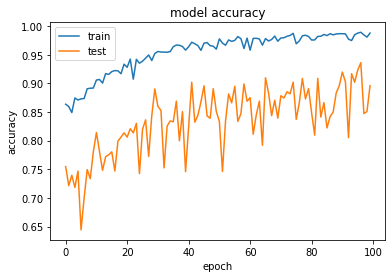

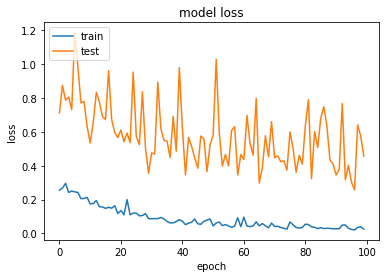

In [77]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [91]:
y_pred = model.predict(X_test)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(y_pred)):
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)

print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 8767 	accurately-predicted-data: 7854 	 wrongly-predicted-data:  913
Accuracy: 89.586 %


In [79]:
best_model = load_model('model.h5')

# compute predictions
y_pred_prob = np.around(best_model.predict(X_test),3)
y_pred = np.argmax(y_pred_prob,axis=1)

y_test2 = np.argmax(y_test,axis=1)

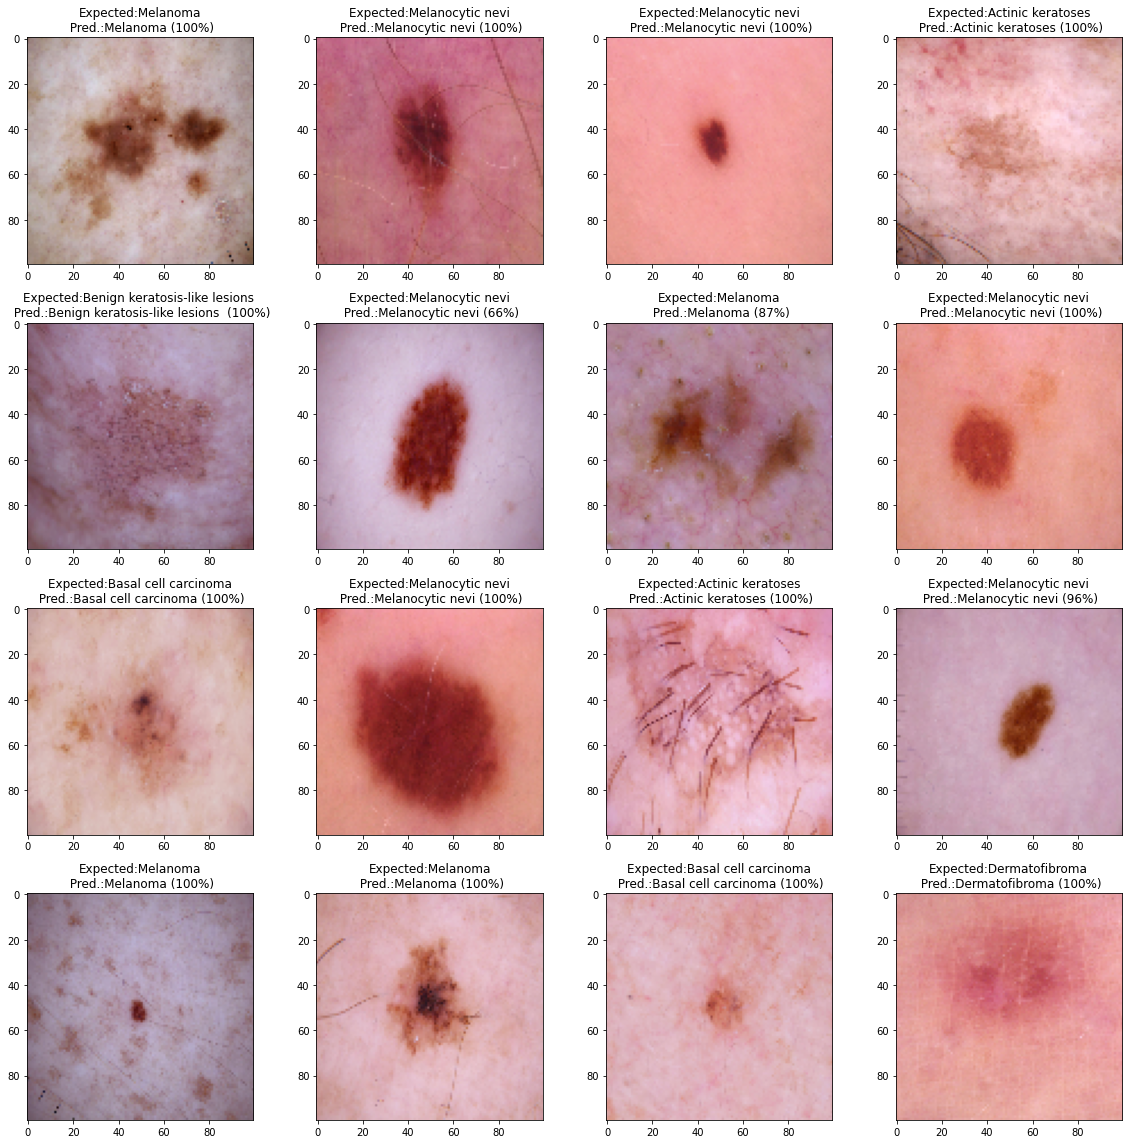

In [80]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    index = i+100
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2[index]]  #expected label
    label_pred = lesion_names[y_pred[index]]  #predicted label
    label_pred_prob = round(np.max(y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_figure.png',dpi=300)
plt.show()

In [81]:
print('Accuracy for label different from 0')
print(np.mean(y_test2[y_test2 != 0] == y_pred[y_test2 != 0]))

Accuracy for label different from 0
0.9548367409215746


In [82]:
acc_tot= []

for i in range(7):
    acc_parz = round(np.mean(y_test2[y_test2 == i] == y_pred[y_test2 == i]),2)
    lab_parz = lesion_names[i]
    print('accuracy for',lab_parz,'=',acc_parz)
    acc_tot.append(acc_parz)

accuracy for Melanocytic nevi = 0.88
accuracy for Melanoma = 0.94
accuracy for Benign keratosis-like lesions  = 0.96
accuracy for Basal cell carcinoma = 0.97
accuracy for Actinic keratoses = 0.93
accuracy for Vascular lesions = 1.0
accuracy for Dermatofibroma = 1.0


In [83]:
acc_tot = np.array(acc_tot)
freq = np.unique(y_test2,return_counts=True)[1]

np.sum(acc_tot*freq)/np.sum(freq)

0.936047678795483

In [84]:
!pip install gradio

In [85]:
import gradio as gr

In [86]:
def predict_image(img):
  img_4d=img.reshape(-1,100,100,3)
  prediction=model.predict(img_4d)[0]
  return {lesion_names[i]: float(prediction[i]) for i in range(7)}

In [87]:
image = gr.inputs.Image(shape=(100,100))
label = gr.outputs.Label(num_top_classes=7)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://32093.gradio.app
Interface loading below...


KeyboardInterrupt: ignored